In [ ]:
# Install all dependencies
!pip install kaggle
!pip install gTTS
!pip install transformers
!pip install seaborn

# Import all libraries

# System & I/O
import os
import random
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio
from gtts import gTTS
import IPython.display as ipd
import tempfile

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1


# Kaggle Setup and Dataset Download

In [ ]:
# Kaggle API setup

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d birdy654/eeg-brainwave-dataset-feeling-emotions
!unzip eeg-brainwave-dataset-feeling-emotions.zip -d eeg_emotion_data

Dataset URL: https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions
License(s): copyright-authors
  0% 0.00/11.9M [00:00<?, ?B/s]
100% 11.9M/11.9M [00:00<00:00, 863MB/s]
Archive:  eeg-brainwave-dataset-feeling-emotions.zip
  inflating: eeg_emotion_data/emotions.csv  


In [ ]:
df = pd.read_csv('/content/eeg_emotion_data/emotions.csv')

print("Shape:", df.shape)
print("Columns:", df.columns[:5].tolist(), '...')
df.head()

Shape: (2132, 2549)
Columns: ['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a'] ...


,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


# Preprocess the Data

In [ ]:
# Encode emotion labels and normalize EEG features

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

X = df.drop(['label', 'label_encoded'], axis=1).values
y = df['label_encoded'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Encoded labels:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Feature shape:", X_scaled.shape)

Encoded labels: {'NEGATIVE': np.int64(0), 'NEUTRAL': np.int64(1), 'POSITIVE': np.int64(2)}
Feature shape: (2132, 2548)


# Train/Validation/Test Split

In [ ]:
# Stratified train/validation/test split

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 1492
Validation size: 320
Test size: 320


# PyTorch Dataset and DataLoaders

In [ ]:
# Creating EEGDataset class and DataLoaders

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# CNN

In [ ]:
class EEG_CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1)
        conv_output_size = ((input_size - 4) // 2 - 2) // 2
        self.fc1 = nn.Linear(32 * conv_output_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

input_size = X_train.shape[1]
num_classes = 3

model = EEG_CNN(input_size=input_size, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


EEG_CNN(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=20320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
# Training the CNN model

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

train_model(model, train_loader, val_loader, epochs=20, lr=0.001)

Epoch 1: Loss = 14.2442, Train Acc = 0.7782, Val Acc = 0.8875
Epoch 2: Loss = 4.7892, Train Acc = 0.9249, Val Acc = 0.9125
Epoch 3: Loss = 3.1486, Train Acc = 0.9531, Val Acc = 0.9469
Epoch 4: Loss = 2.2585, Train Acc = 0.9718, Val Acc = 0.9531
Epoch 5: Loss = 1.5816, Train Acc = 0.9759, Val Acc = 0.9563
Epoch 6: Loss = 0.9918, Train Acc = 0.9899, Val Acc = 0.9719
Epoch 7: Loss = 0.6185, Train Acc = 0.9966, Val Acc = 0.9500
Epoch 8: Loss = 0.3827, Train Acc = 0.9993, Val Acc = 0.9656
Epoch 9: Loss = 0.2600, Train Acc = 0.9993, Val Acc = 0.9688
Epoch 10: Loss = 0.1704, Train Acc = 1.0000, Val Acc = 0.9656
Epoch 11: Loss = 0.1262, Train Acc = 1.0000, Val Acc = 0.9625
Epoch 12: Loss = 0.1079, Train Acc = 1.0000, Val Acc = 0.9688
Epoch 13: Loss = 0.1204, Train Acc = 1.0000, Val Acc = 0.9656
Epoch 14: Loss = 0.0592, Train Acc = 1.0000, Val Acc = 0.9688
Epoch 15: Loss = 0.0434, Train Acc = 1.0000, Val Acc = 0.9688
Epoch 16: Loss = 0.0412, Train Acc = 1.0000, Val Acc = 0.9625
Epoch 17: Loss =

              precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       107
     NEUTRAL       1.00      0.97      0.99       107
    POSITIVE       0.96      0.97      0.97       106

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



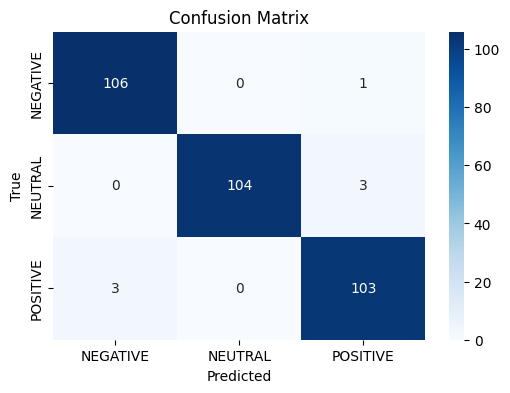

In [ ]:
# Evaluation of the model on test set

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# EEGNet

In [ ]:
class EEGNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=64, padding=32, bias=False),
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size=1, bias=False),
            nn.BatchNorm1d(16),
            nn.ELU(),
            nn.AvgPool1d(kernel_size=4),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=16, padding=8, bias=False),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.AvgPool1d(kernel_size=8),
            nn.Dropout(0.25)
        )
        self.fc = nn.Linear(self._get_flattened_size(input_size), num_classes)

    def _get_flattened_size(self, input_size):
        with torch.no_grad():
            x = torch.zeros(1, 1, input_size)
            x = self.layer1(x)
            x = self.layer2(x)
            return x.shape[1] * x.shape[2]

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Initialize EEGNet

eegnet_model = EEGNet(input_size=X_train.shape[1], num_classes=3)
eegnet_model.to(device)

EEGNet(
  (layer1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(64,), stride=(1,), padding=(32,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv1d(8, 16, kernel_size=(1,), stride=(1,), bias=False)
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
    (6): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(16,), stride=(1,), padding=(8,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool1d(kernel_size=(8,), stride=(8,), padding=(0,))
    (4): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=2528, out_features=3, bias=True)
)

In [ ]:
# Train EEGNet
train_model(eegnet_model, train_loader, val_loader, epochs=20, lr=0.001)

Epoch 1: Loss = 9.2684, Train Acc = 0.8378, Val Acc = 0.9000
Epoch 2: Loss = 5.0652, Train Acc = 0.9109, Val Acc = 0.9031
Epoch 3: Loss = 4.4548, Train Acc = 0.9202, Val Acc = 0.9344
Epoch 4: Loss = 4.0270, Train Acc = 0.9363, Val Acc = 0.9094
Epoch 5: Loss = 3.3650, Train Acc = 0.9497, Val Acc = 0.9094
Epoch 6: Loss = 3.6429, Train Acc = 0.9424, Val Acc = 0.9187
Epoch 7: Loss = 3.0913, Train Acc = 0.9450, Val Acc = 0.9375
Epoch 8: Loss = 3.0892, Train Acc = 0.9471, Val Acc = 0.9375
Epoch 9: Loss = 2.4034, Train Acc = 0.9665, Val Acc = 0.9375
Epoch 10: Loss = 2.3157, Train Acc = 0.9685, Val Acc = 0.9500
Epoch 11: Loss = 2.4081, Train Acc = 0.9638, Val Acc = 0.9344
Epoch 12: Loss = 2.0207, Train Acc = 0.9665, Val Acc = 0.9469
Epoch 13: Loss = 1.8968, Train Acc = 0.9745, Val Acc = 0.9375
Epoch 14: Loss = 1.7525, Train Acc = 0.9739, Val Acc = 0.9187
Epoch 15: Loss = 1.9263, Train Acc = 0.9718, Val Acc = 0.9437
Epoch 16: Loss = 1.8572, Train Acc = 0.9725, Val Acc = 0.9531
Epoch 17: Loss = 

              precision    recall  f1-score   support

    NEGATIVE       0.95      0.97      0.96       107
     NEUTRAL       0.99      0.97      0.98       107
    POSITIVE       0.94      0.94      0.94       106

    accuracy                           0.96       320
   macro avg       0.96      0.96      0.96       320
weighted avg       0.96      0.96      0.96       320



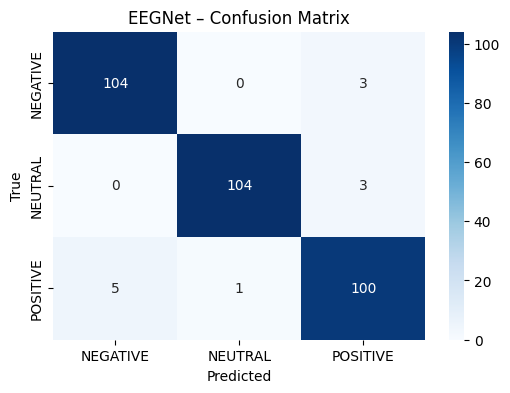

In [ ]:
# Evaluate EEGNet on test set
eegnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = eegnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EEGNet – Confusion Matrix")
plt.show()

# LSTM

In [ ]:
# Reshaping the features for LSTM input

time_steps = 49
features_per_step = 52

X_train_seq = X_train.reshape(-1, time_steps, features_per_step)
X_val_seq   = X_val.reshape(-1, time_steps, features_per_step)
X_test_seq  = X_test.reshape(-1, time_steps, features_per_step)

print("Reshaped X_train:", X_train_seq.shape)

Reshaped X_train: (1492, 49, 52)


In [ ]:
# PyTorch Dataset for LSTM
class EEGLSTMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_dataset_lstm = EEGLSTMDataset(X_train_seq, y_train)
val_dataset_lstm = EEGLSTMDataset(X_val_seq, y_val)
test_dataset_lstm = EEGLSTMDataset(X_test_seq, y_test)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=batch_size)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size)


In [ ]:
class EEG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Taking the last time step output
        out = self.fc(out)
        return out

In [ ]:
input_size = 52
hidden_size = 64
num_layers = 2
num_classes = 3

model_lstm = EEG_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Training the LSTM model
train_model(model_lstm, train_loader_lstm, val_loader_lstm, epochs=20, lr=0.001)

Epoch 1: Loss = 24.0584, Train Acc = 0.7346, Val Acc = 0.8063
Epoch 2: Loss = 11.8329, Train Acc = 0.8465, Val Acc = 0.8906
Epoch 3: Loss = 6.2079, Train Acc = 0.9021, Val Acc = 0.8938
Epoch 4: Loss = 5.2315, Train Acc = 0.9196, Val Acc = 0.9094
Epoch 5: Loss = 4.3209, Train Acc = 0.9390, Val Acc = 0.9094
Epoch 6: Loss = 4.0621, Train Acc = 0.9444, Val Acc = 0.9281
Epoch 7: Loss = 3.2838, Train Acc = 0.9564, Val Acc = 0.9281
Epoch 8: Loss = 3.4444, Train Acc = 0.9564, Val Acc = 0.9406
Epoch 9: Loss = 2.8172, Train Acc = 0.9645, Val Acc = 0.9563
Epoch 10: Loss = 2.4677, Train Acc = 0.9651, Val Acc = 0.9344
Epoch 11: Loss = 2.1837, Train Acc = 0.9772, Val Acc = 0.9625
Epoch 12: Loss = 2.0869, Train Acc = 0.9765, Val Acc = 0.9500
Epoch 13: Loss = 2.4838, Train Acc = 0.9705, Val Acc = 0.9469
Epoch 14: Loss = 2.4851, Train Acc = 0.9712, Val Acc = 0.9563
Epoch 15: Loss = 2.1554, Train Acc = 0.9765, Val Acc = 0.9469
Epoch 16: Loss = 1.7251, Train Acc = 0.9846, Val Acc = 0.9531
Epoch 17: Loss 

              precision    recall  f1-score   support

    NEGATIVE       0.90      0.97      0.94       107
     NEUTRAL       0.98      0.95      0.97       107
    POSITIVE       0.92      0.88      0.90       106

    accuracy                           0.93       320
   macro avg       0.94      0.93      0.93       320
weighted avg       0.94      0.93      0.93       320



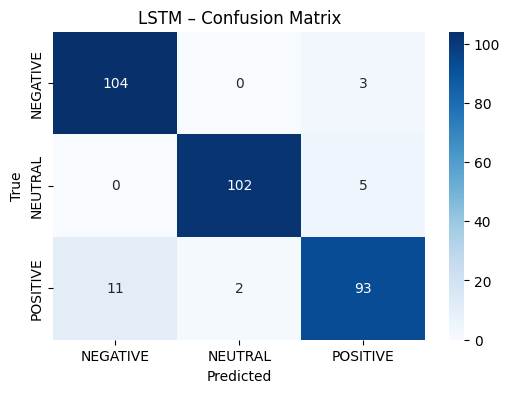

In [ ]:
# Evaluating LSTM on test set
model_lstm.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_lstm:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_lstm(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LSTM – Confusion Matrix")
plt.show()

# Knowledge Distillation

In [ ]:
# Smaller Student Model
class StudentCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(StudentCNN, self).__init__()
        self.conv = nn.Conv1d(1, 8, kernel_size=5, stride=1)
        self.pool = nn.MaxPool1d(2)
        conv_output_size = (input_size - 4) // 2
        self.fc1 = nn.Linear(8 * conv_output_size, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

student_model = StudentCNN(input_size=X_train.shape[1], num_classes=3).to(device)

In [ ]:
# Distillation Loss Function
def distillation_loss(y_student, y_teacher, y_true, temperature=4, alpha=0.7):
    """
    y_student: logits from student
    y_teacher: logits from teacher
    y_true: true labels
    temperature: softening temperature
    alpha: weight for soft loss
    """
    soft_loss = nn.KLDivLoss()(F.log_softmax(y_student/temperature, dim=1),
                               F.softmax(y_teacher/temperature, dim=1)) * (temperature**2)
    hard_loss = F.cross_entropy(y_student, y_true)
    return alpha * soft_loss + (1 - alpha) * hard_loss

In [ ]:
# Training student with distillation
def train_distillation(student_model, teacher_model, train_loader, val_loader, epochs=20, lr=0.001):
    optimizer = optim.Adam(student_model.parameters(), lr=lr)
    teacher_model.eval()

    for epoch in range(epochs):
        student_model.train()
        total_loss = 0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            optimizer.zero_grad()
            student_outputs = student_model(inputs)

            loss = distillation_loss(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            correct += (predicted == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # Validation
        student_model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")


In [ ]:
# distillation training
train_distillation(student_model, model, train_loader, val_loader, epochs=20, lr=0.001)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1: Loss = 42.4772, Train Acc = 0.7332, Val Acc = 0.8469


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 2: Loss = 15.9601, Train Acc = 0.8995, Val Acc = 0.9125


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 3: Loss = 7.8356, Train Acc = 0.9403, Val Acc = 0.9281


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 4: Loss = 5.9324, Train Acc = 0.9511, Val Acc = 0.9563


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 5: Loss = 4.3534, Train Acc = 0.9665, Val Acc = 0.9594


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 6: Loss = 3.0638, Train Acc = 0.9745, Val Acc = 0.9688


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 7: Loss = 2.0988, Train Acc = 0.9859, Val Acc = 0.9500


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 8: Loss = 1.6254, Train Acc = 0.9920, Val Acc = 0.9375


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 9: Loss = 1.4427, Train Acc = 0.9933, Val Acc = 0.9563


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 10: Loss = 1.2117, Train Acc = 0.9953, Val Acc = 0.9719


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 11: Loss = 0.7865, Train Acc = 0.9993, Val Acc = 0.9594
Epoch 12: Loss = 0.7395, Train Acc = 1.0000, Val Acc = 0.9531


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 13: Loss = 0.6163, Train Acc = 1.0000, Val Acc = 0.9625


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 14: Loss = 0.5088, Train Acc = 1.0000, Val Acc = 0.9750


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 15: Loss = 0.3888, Train Acc = 1.0000, Val Acc = 0.9719


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 16: Loss = 0.3437, Train Acc = 1.0000, Val Acc = 0.9688


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 17: Loss = 0.3079, Train Acc = 1.0000, Val Acc = 0.9688


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 18: Loss = 0.4888, Train Acc = 0.9993, Val Acc = 0.9781


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 19: Loss = 0.7783, Train Acc = 1.0000, Val Acc = 0.9750


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 20: Loss = 0.4780, Train Acc = 1.0000, Val Acc = 0.9688


              precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.98       107
     NEUTRAL       0.99      0.96      0.98       107
    POSITIVE       0.95      0.95      0.95       106

    accuracy                           0.97       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320



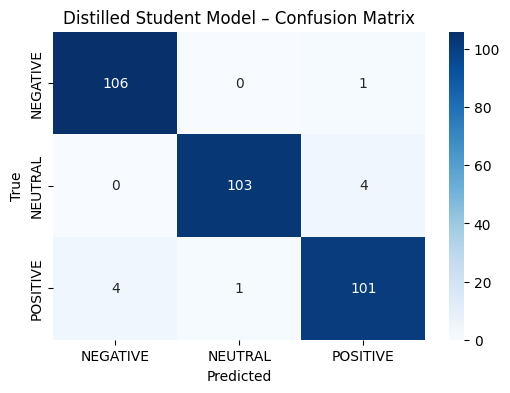

In [ ]:
# evaluating distilled student model on test set
student_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = student_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Distilled Student Model – Confusion Matrix")
plt.show()


# Comparative Analysis

In [ ]:
model_results = {
    'Model': ['1D CNN (Teacher)', 'EEGNet', 'LSTM', 'Distilled CNN'],
    'Test Accuracy': [0.98, 0.96, 0.93, 0.97],
    'Macro F1 Score': [0.98, 0.96, 0.93, 0.97],
    'Notes': [
        'Largest model, highest accuracy',
        'EEG-specific, compact',
        'Temporal dynamics captured',
        'Smallest, nearly same accuracy'
    ]
}

results_df = pd.DataFrame(model_results)
print(results_df)


              Model  Test Accuracy  Macro F1 Score  \
0  1D CNN (Teacher)           0.98            0.98   
1            EEGNet           0.96            0.96   
2              LSTM           0.93            0.93   
3     Distilled CNN           0.97            0.97   

                             Notes  
0  Largest model, highest accuracy  
1            EEG-specific, compact  
2       Temporal dynamics captured  
3   Smallest, nearly same accuracy  


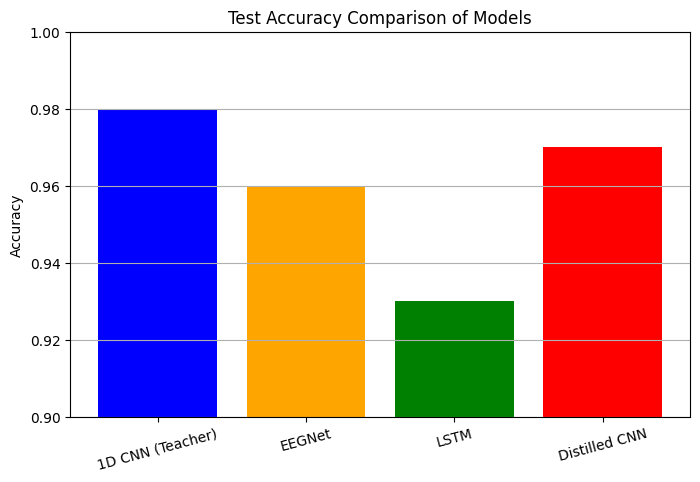

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['Test Accuracy'], color=['blue', 'orange', 'green', 'red'])
plt.ylim([0.9, 1.0])
plt.title('Test Accuracy Comparison of Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()


# GPT-2 Text Generation + TTS

In [ ]:
# GPT-2 Text Generation
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
model_gpt2.eval()

def generate_sentence_gpt2(emotion_label, max_length=30):
    prompt = f"The person is feeling {emotion_label.lower()}. Encourage them with a helpful sentence:"
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    with torch.no_grad():
        output = model_gpt2.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    sentence = generated_text.replace(prompt, "").strip()
    return sentence

# Example
for emotion in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
    print(f"{emotion} → {generate_sentence_gpt2(emotion)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


NEGATIVE → "I'm sorry, but I'm not sure what to do."
NEUTRAL → "I'm not going to hurt you."

"I don't know
POSITIVE → "I'm feeling good."

"I feel good," says the person


In [ ]:
# Text-to-Speech (TTS) Using gTTS
def speak_text(text, lang='en'):
    tts = gTTS(text=text, lang=lang)
    with tempfile.NamedTemporaryFile(delete=True) as fp:
        tts.save("temp.mp3")
        return ipd.Audio("temp.mp3")

# Example
sample_text = generate_sentence_gpt2('POSITIVE')
print("Generated sentence:", sample_text)
speak_text(sample_text)


Generated sentence: "I'm feeling good."

"I feel good," says the person


# Sample Predictions and Outputs

In [ ]:
emotions = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']

for emotion in emotions:
    sentence = generate_sentence_gpt2(emotion)
    print(f"Emotion: {emotion}")
    print(f"Generated sentence: {sentence}")
    display(speak_text(sentence))
    print('---')

Emotion: NEGATIVE
Generated sentence: "I'm sorry, but I'm not sure what to do."


---
Emotion: NEUTRAL
Generated sentence: "I'm not going to hurt you."

"I don't know


---
Emotion: POSITIVE
Generated sentence: "I'm feeling good."

"I feel good," says the person


---
